In [1]:
import os
import random

import numpy as np
import torch
from peft import LoraConfig, TaskType, get_peft_model
from torch import nn


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


class ModelForSourceCodeEmbedding(nn.Module):
    def __init__(self, model_name, normalize=True):
        super(ModelForSourceCodeEmbedding, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.normalize = normalize

    def forward(self, **kwargs):
        model_output = self.model(**kwargs)
        embeddings = self.average_pool(model_output, kwargs.get("attention_mask"))
        if self.normalize:
            embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        return embeddings

    def average_pool(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return (torch.sum(token_embeddings * input_mask_expanded, 1) /
                torch.clamp(input_mask_expanded.sum(1), min=1e-9))

    def __getattr__(self, name: str):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.model, name)

In [2]:
from transformers import AutoModel, AutoTokenizer


model_name = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = ModelForSourceCodeEmbedding(model_name)

In [3]:
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION,
    target_modules=["key", "query", "value"],
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 442,368 || all params: 125,088,000 || trainable%: 0.3536


In [4]:
torch.cuda.empty_cache()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [6]:
def get_cosing(q1_embs, q2_embs):
    return torch.sum(q1_embs * q2_embs, axis=1)

def get_loss(cosine_score, labels):
    return torch.mean(torch.square(labels * (1 - cosine_score) + torch.clamp((1 - labels) * cosine_score, min=0.0)))

def threshold(x):
    return 1 if x > 0.5 else 0

In [7]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm


train_cases = ["case-01", "case-02", "case-03", "case-04", "case-05"]
test_cases = ["case-06", "case-07"]

train_df = pd.DataFrame(data=None, columns=["original_code_file", "secondary_code_file", "label"])
test_df = pd.DataFrame(data=None, columns=["original_code_file", "secondary_code_file", "label"])

def add_to_df(df, original_code_file, secondary_code_file, label):
        df.loc[len(train_df)] = [original_code_file, secondary_code_file, label]
    
def get_data(df, original_file_path, non_plagiarized_files_paths, plagiarized_files_paths):
    for non_plagiarized_file_path in non_plagiarized_files_paths:
        add_to_df(df, original_file_path, non_plagiarized_file_path, 0)
    for plagiarized_file_path in plagiarized_files_paths:
        add_to_df(df, original_file_path, plagiarized_file_path, 1)

def get_paths(case):
    original_file_path = os.path.join("plagiarism_dataset", case, "original", os.listdir(f"plagiarism_dataset/{case}/original")[0])

    non_plagiarized_files_paths = [os.path.join("plagiarism_dataset", case, "non-plagiarized", file) for file in os.listdir(f"plagiarism_dataset/{case}/non-plagiarized")]
    non_plagiarized_files_paths = [os.path.join(file_path, os.listdir(file_path)[0]) for file_path in non_plagiarized_files_paths]

    plagiarized_files_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(os.path.join("plagiarism_dataset", case, "plagiarized")) for f in filenames if os.path.splitext(f)[1] == '.java']
    
    return original_file_path, non_plagiarized_files_paths, plagiarized_files_paths
    

# train-test cycle:
EPOCHS = 15

epochs_losses_train = []
epochs_accuracies_train = []

epochs_losses_test = []
epochs_accuracies_test = []

for epoch in range(EPOCHS):
    train_total_loss = 0
    train_correct = 0
    
    test_total_loss = 0
    test_correct = 0
    
    # train:
    for case in train_cases:
        original_file_path, non_plagiarized_files_paths, plagiarized_files_paths = get_paths(case)
        get_data(train_df, original_file_path, non_plagiarized_files_paths, plagiarized_files_paths)
        train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
        X_train, X_test, y_train, y_test = train_test_split(train_df[["original_code_file", "secondary_code_file"]], train_df["label"], test_size=0.2, random_state=42)
    
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)
        
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        X_test = X_test.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)
    
        optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
        loss = nn.CrossEntropyLoss()
        
        total_loss = 0
        correct = 0
        
        model.train()
        bar = tqdm(range(len(X_train)))
        for i in range(len(X_train)):
            original_code = open(X_train["original_code_file"][i], "r").read()
            secondary_code = open(X_train["secondary_code_file"][i], "r").read()
            
            q1 = tokenizer(original_code, return_tensors="pt", max_length=512, truncation=True)
            q2 = tokenizer(secondary_code, return_tensors="pt", max_length=512, truncation=True)
            
            q1 = {k: v.to(device) for k, v in q1.items()}
            q2 = {k: v.to(device) for k, v in q2.items()}
            
            label = torch.tensor([y_train[i]])
            label = label.to(device)
            
            optimizer.zero_grad()
            q1 = model(**q1)
            q2 = model(**q2)
            loss_value = get_loss(get_cosing(q1, q2).to(device), label)
            total_loss += loss_value.item()
            loss_value.backward()
            optimizer.step()
        
            prediction = threshold(get_cosing(q1, q2).item())
            if prediction == label:
                correct += 1
            bar.update(1)
        
        train_total_loss += total_loss / len(X_train)
        train_correct += correct / len(X_train)

    # test:
    for case in test_cases:
        original_file_path, non_plagiarized_files_paths, plagiarized_files_paths = get_paths(case)
        get_data(test_df, original_file_path, non_plagiarized_files_paths, plagiarized_files_paths)
        test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
        X_test, y_test = test_df[["original_code_file", "secondary_code_file"]], test_df["label"]
    
        # val:
        total_loss = 0
        correct = 0
        
        model.eval()
        bar = tqdm(range(len(X_test)))
        for i in range(len(X_test)):
            original_code = open(X_test["original_code_file"][i], "r").read()
            secondary_code = open(X_test["secondary_code_file"][i], "r").read()
            
            q1 = tokenizer(original_code, return_tensors="pt", max_length=512, truncation=True)
            q2 = tokenizer(secondary_code, return_tensors="pt", max_length=512, truncation=True)
            
            q1 = {k: v.to(device) for k, v in q1.items()}
            q2 = {k: v.to(device) for k, v in q2.items()}
            
            label = torch.tensor([y_test[i]])
            label = label.to(device)
            
            q1 = model(**q1)
            q2 = model(**q2)
            loss_value = get_loss(get_cosing(q1, q2).to(device), label)
            total_loss += loss_value.item()
            
            prediction = threshold(get_cosing(q1, q2).item())
            if prediction == label:
                correct += 1
            bar.update(1)
        
        test_total_loss += total_loss / len(X_test)
        test_correct += correct / len(X_test)
    
    epochs_losses_train.append(train_total_loss / 5)
    print(f"Epoch: {epoch}, Loss train: {train_total_loss / 5}")
    epochs_accuracies_train.append(train_correct / 5)
    print(f"Epoch: {epoch}, Accuracy train: {train_correct / 5}")
    
    epochs_losses_test.append(test_total_loss / 2)
    print(f"Epoch: {epoch}, Loss test: {test_total_loss / 2}")
    epochs_accuracies_test.append(test_correct / 2)
    print(f"Epoch: {epoch}, Accuracy test: {test_correct / 2}")

  0%|          | 0/62 [00:00<?, ?it/s]C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 62/62 [00:07<00:00,  7.79it/s]

100%|██████████| 234/234 [00:36<00:00,  6.43it/s]

100%|██████████| 2/2 [00:00<00:00, 12.99it/s]

Epoch: 0, Loss train: 0.2428898627448277
Epoch: 0, Accuracy train: 0.6882237454514681
Epoch: 0, Loss test: 1.5373471975326538
Epoch: 0, Accuracy test: 0.0



100%|██████████| 2/2 [00:00<00:00,  8.67it/s]

100%|██████████| 556/556 [01:12<00:00,  7.65it/s]

100%|██████████| 726/726 [01:42<00:00,  7.06it/s]

100%|██████████| 3/3 [00:00<00:00, 12.53it/s]

100%|██████████| 4/4 [00:00<00:00, 13.33it/s]

Epoch: 1, Loss train: 0.11747255877688148
Epoch: 1, Accuracy train: 0.8408532173225719
Epoch: 1, Loss test: 0.8278323660294216
Epoch: 1, Accuracy test: 0.0


100%|██████████| 862/862 [01:55<00:00,  7.46it/s]

100%|██████████| 1048/1048 [02:26<00:00,  7.14it/s]

100%|██████████| 1194/1194 [02:45<00:00,  7.23it/s]

100%|██████████| 6/6 [00:00<00:00, 13.84it/s]

Epoch: 2, Loss train: 0.04107806270602573
Epoch: 2, Accuracy train: 0.9445928502902614
Epoch: 2, Loss test: 0.30058939824812114
Epoch: 2, Accuracy test: 0.45



100%|██████████| 6/6 [00:00<00:00, 11.52it/s]

100%|██████████| 1352/1352 [03:02<00:00,  7.42it/s]

100%|██████████| 1524/1524 [03:29<00:00,  7.26it/s]

100%|██████████| 7/7 [00:00<00:00, 13.10it/s]

100%|██████████| 8/8 [00:00<00:00, 13.54it/s]

Epoch: 3, Loss train: 0.009413558138947706
Epoch: 3, Accuracy train: 0.9898000931064482
Epoch: 3, Loss test: 0.14911099686287344
Epoch: 3, Accuracy test: 0.4642857142857143


100%|██████████| 1680/1680 [03:49<00:00,  7.32it/s]

100%|██████████| 1874/1874 [04:20<00:00,  7.19it/s]

100%|██████████| 2034/2034 [04:35<00:00,  7.38it/s]

100%|██████████| 10/10 [00:00<00:00, 14.30it/s]

Epoch: 4, Loss train: 0.0032257185795420487
Epoch: 4, Accuracy train: 0.9961176737751023
Epoch: 4, Loss test: 0.44094054513213143
Epoch: 4, Accuracy test: 0.4722222222222222



100%|██████████| 10/10 [00:00<00:00, 12.21it/s]

100%|██████████| 2186/2186 [04:50<00:00,  7.52it/s]

100%|██████████| 2328/2328 [05:10<00:00,  7.49it/s]

100%|██████████| 11/11 [00:00<00:00, 13.32it/s]

100%|██████████| 12/12 [00:00<00:00, 13.41it/s]

Epoch: 5, Loss train: 0.0016872523503600756
Epoch: 5, Accuracy train: 0.9982295313020633
Epoch: 5, Loss test: 0.0004236309786475348
Epoch: 5, Accuracy test: 1.0


100%|██████████| 2484/2484 [05:31<00:00,  7.50it/s]

100%|██████████| 2670/2670 [06:00<00:00,  7.41it/s]

100%|██████████| 2842/2842 [06:21<00:00,  7.44it/s]

100%|██████████| 14/14 [00:01<00:00, 13.85it/s]

Epoch: 6, Loss train: 0.00086253710797939
Epoch: 6, Accuracy train: 0.998998297462611
Epoch: 6, Loss test: 0.9677400497289804
Epoch: 6, Accuracy test: 0.0



100%|██████████| 14/14 [00:01<00:00, 12.58it/s]

100%|██████████| 2988/2988 [06:38<00:00,  7.49it/s]

100%|██████████| 3186/3186 [07:06<00:00,  7.46it/s]

100%|██████████| 15/15 [00:01<00:00, 13.06it/s]

100%|██████████| 16/16 [00:01<00:00, 13.51it/s]

Epoch: 7, Loss train: 0.0004893543127598898
Epoch: 7, Accuracy train: 0.9996048478941619
Epoch: 7, Loss test: 0.0002509140710496164
Epoch: 7, Accuracy test: 1.0


100%|██████████| 3284/3284 [07:15<00:00,  7.54it/s]

100%|██████████| 3480/3480 [07:50<00:00,  7.40it/s]

100%|██████████| 3638/3638 [08:07<00:00,  7.46it/s]

100%|██████████| 18/18 [00:01<00:00, 12.83it/s]

Epoch: 8, Loss train: 0.00022235076749666403
Epoch: 8, Accuracy train: 0.9997113287089595
Epoch: 8, Loss test: 3.56971702316437e-05
Epoch: 8, Accuracy test: 1.0



100%|██████████| 18/18 [00:01<00:00, 12.78it/s]

100%|██████████| 3794/3794 [08:28<00:00,  7.46it/s]

100%|██████████| 3970/3970 [08:49<00:00,  7.50it/s]

100%|██████████| 19/19 [00:01<00:00, 13.35it/s]

100%|██████████| 20/20 [00:01<00:00, 14.10it/s]

Epoch: 9, Loss train: 0.00025335606768411644
Epoch: 9, Accuracy train: 0.9997386477166078
Epoch: 9, Loss test: 2.4632822086936548
Epoch: 9, Accuracy test: 0.0


100%|██████████| 4104/4104 [09:02<00:00,  7.56it/s]

100%|██████████| 4266/4266 [09:37<00:00,  7.39it/s]

100%|██████████| 4470/4470 [09:59<00:00,  7.46it/s]

100%|██████████| 22/22 [00:01<00:00, 13.34it/s]

Epoch: 10, Loss train: 0.0005602145421011398
Epoch: 10, Accuracy train: 0.9996260412089212
Epoch: 10, Loss test: 4.1747926397619375e-05
Epoch: 10, Accuracy test: 1.0



100%|██████████| 22/22 [00:01<00:00, 12.90it/s]

100%|██████████| 4646/4646 [10:23<00:00,  7.45it/s]

100%|██████████| 4762/4762 [10:39<00:00,  7.45it/s]

100%|██████████| 23/23 [00:01<00:00, 13.31it/s]

100%|██████████| 24/24 [00:01<00:00, 13.70it/s]

Epoch: 11, Loss train: 0.00030116441736875553
Epoch: 11, Accuracy train: 0.9996562525506743
Epoch: 11, Loss test: 1.0874465186948625
Epoch: 11, Accuracy test: 0.4891304347826087


100%|██████████| 4912/4912 [11:04<00:00,  7.39it/s]

100%|██████████| 5082/5082 [11:30<00:00,  7.36it/s]

100%|██████████| 5242/5242 [11:43<00:00,  7.45it/s]

100%|██████████| 26/26 [00:01<00:00, 13.53it/s]

Epoch: 12, Loss train: 0.00014326952119736368
Epoch: 12, Accuracy train: 0.9998384955780573
Epoch: 12, Loss test: 2.2025892829895017
Epoch: 12, Accuracy test: 0.0



100%|██████████| 26/26 [00:02<00:00, 12.58it/s]

100%|██████████| 5410/5410 [12:10<00:00,  7.40it/s]

100%|██████████| 5568/5568 [12:31<00:00,  7.41it/s]

100%|██████████| 27/27 [00:02<00:00, 13.33it/s]

100%|██████████| 28/28 [00:02<00:00, 12.78it/s]

Epoch: 13, Loss train: 0.00021918023722293894
Epoch: 13, Accuracy train: 0.9998906233820026
Epoch: 13, Loss test: 9.119026521552264e-12
Epoch: 13, Accuracy test: 1.0


100%|██████████| 5718/5718 [12:51<00:00,  7.41it/s]

100%|██████████| 5894/5894 [13:18<00:00,  7.38it/s]

100%|██████████| 6080/6080 [13:37<00:00,  7.44it/s]

100%|██████████| 30/30 [00:02<00:00, 12.96it/s]

Epoch: 14, Loss train: 0.0006635390971496289
Epoch: 14, Accuracy train: 0.9996273496437734
Epoch: 14, Loss test: 1.24378668284282e-12
Epoch: 14, Accuracy test: 1.0


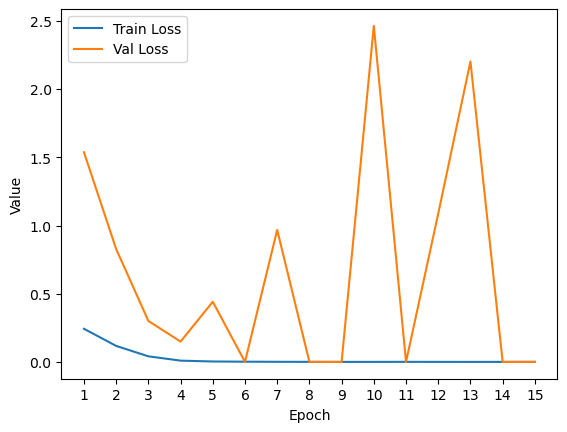

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(1, EPOCHS + 1), epochs_losses_train, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), epochs_losses_test, label="Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(range(1, EPOCHS + 1))

plt.show()

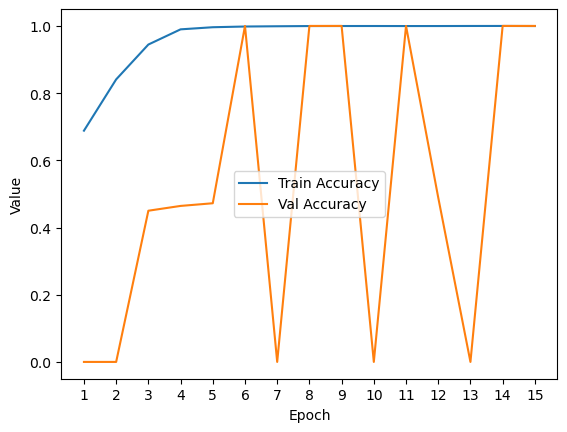

In [9]:
plt.plot(range(1, EPOCHS + 1), epochs_accuracies_train, label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), epochs_accuracies_test, label="Val Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(range(1, EPOCHS + 1))

plt.show()

In [10]:
torch.save(model, "code_embedding_model.pth")

In [11]:
# model = torch.load("code_embedding_model.pth")
# model.eval()

In [14]:
epochs_losses_test, len(epochs_losses_test)

([1.5373471975326538,
  0.8278323660294216,
  0.30058939824812114,
  0.14911099686287344,
  0.44094054513213143,
  0.0004236309786475348,
  0.9677400497289804,
  0.0002509140710496164,
  3.56971702316437e-05,
  2.4632822086936548,
  4.1747926397619375e-05,
  1.0874465186948625,
  2.2025892829895017,
  9.119026521552264e-12,
  1.24378668284282e-12],
 15)